In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.16 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.7 which is incompatible.
langchain-community 0.2.16 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.7 which is incompatible.
langchain-text-splitters 0.2.4 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.7 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from langchain_openai import ChatOpenAI

# Initialize the LLM with your API key directly
model = ChatOpenAI(model="gpt-4o-mini", api_key="")

In [5]:
!pip install --quiet -U langchain_core langgraph langchain_openai



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [9]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [10]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 3:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

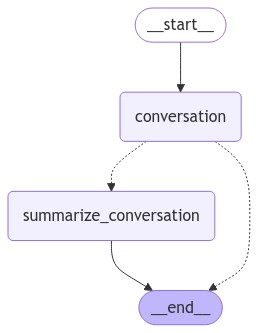

In [11]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "2"}}


# Start conversation
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        break
    
    input_message = HumanMessage(content=user_input)
    output = graph.invoke({"messages": [input_message]}, config)
    
    print("AI:", output['messages'][-1].content)
    
    # Print the current summary after each interaction
    summary = graph.get_state(config).values.get("summary", "")
    print("\nCurrent Summary:", summary)
    print("-" * 50)

print("Conversation ended.")

AI: Hello! How can I assist you today?

Current Summary: 
--------------------------------------------------
AI: Hi, Musaed! It's nice to meet you. How can I help you today?

Current Summary: 
--------------------------------------------------
AI: That's great to hear! AI is a fascinating field with so much potential. What aspects of AI do you love the most?

Current Summary: 
--------------------------------------------------
AI: Awesome! Football (or soccer, depending on where you are) is such an exciting sport. Do you have a favorite team or player?

Current Summary: In the conversation, Musaed expresses a love for both AI and football. He introduces himself and shares his enthusiasm for these topics. The interaction includes a friendly exchange, with the assistant asking about Musaed's favorite aspects of AI and his favorite football team or player.
--------------------------------------------------
Conversation ended.


In [21]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

from langchain_openai import ChatOpenAI

# Initialize the LLM with your API key
model = ChatOpenAI(model="gpt-4o-mini", api_key="sk-...")


from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}



def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 3:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# Start conversation
config = {"configurable": {"thread_id": "3"}}

while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        break
    
    input_message = HumanMessage(content=user_input)
    output = graph.invoke({"messages": [input_message]}, config)
    
    print("AI:", output['messages'][-1].content)
    
    summary = graph.get_state(config).values.get("summary", "")
    print("\nCurrent Summary:", summary)
    print("-" * 50)

print("Conversation ended.")

NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4-mini` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [25]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START



class State(MessagesState):
    summary: str


# Initialize the LLM with your API key
model = ChatOpenAI(model="gpt-4o-mini",
                    api_key="sk-p...")



# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}



def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 3:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END



# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# Start conversation
config = {"configurable": {"thread_id": "4"}}

while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        break
    
    input_message = HumanMessage(content=user_input)
    output = graph.invoke({"messages": [input_message]}, config)
    
    print("AI:", output['messages'][-1].content)
    
    summary = graph.get_state(config).values.get("summary", "")
    print("\nCurrent Summary:", summary)
    print("-" * 50)

print("Conversation ended.")

AI: Hello! How can I assist you today?

Current Summary: 
--------------------------------------------------
Conversation ended.
